In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageChops
from tqdm import tqdm

In [3]:
data_dir = "../data/cell_images"
parasitized_dir = os.path.join(data_dir, "Parasitized")
uninfected_dir = os.path.join(data_dir, "Uninfected")

Parasitized images: 13780
Uninfected images: 13780


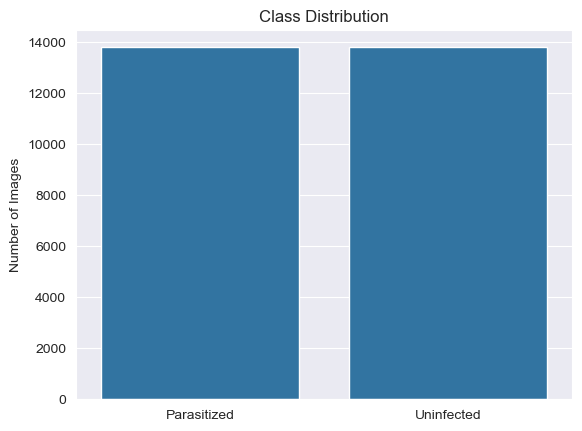

In [4]:
num_parasitized = len(os.listdir(parasitized_dir))
num_uninfected = len(os.listdir(uninfected_dir))

print(f"Parasitized images: {num_parasitized}")
print(f"Uninfected images: {num_uninfected}")

sns.barplot(x=["Parasitized", "Uninfected"], y=[num_parasitized, num_uninfected])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

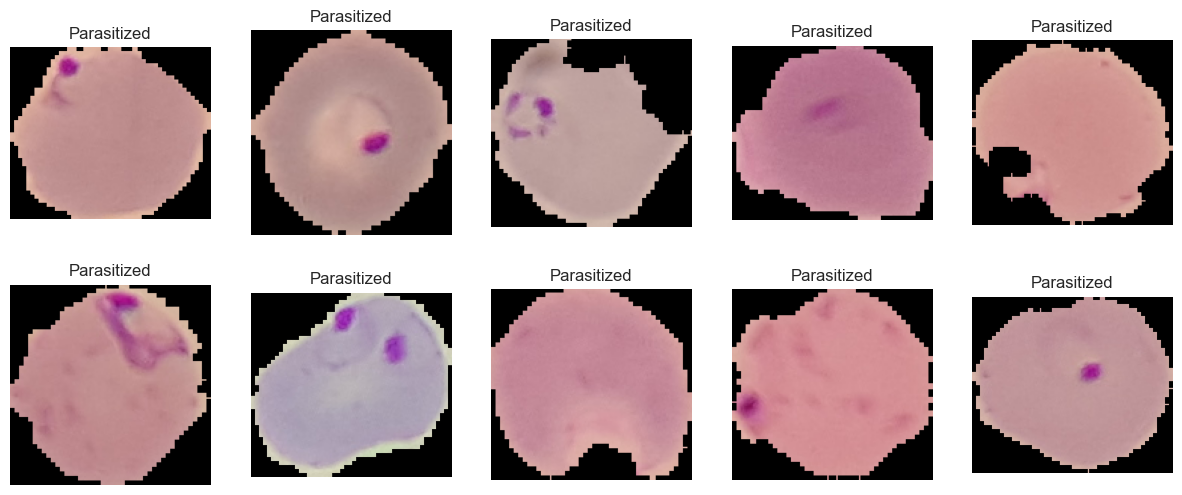

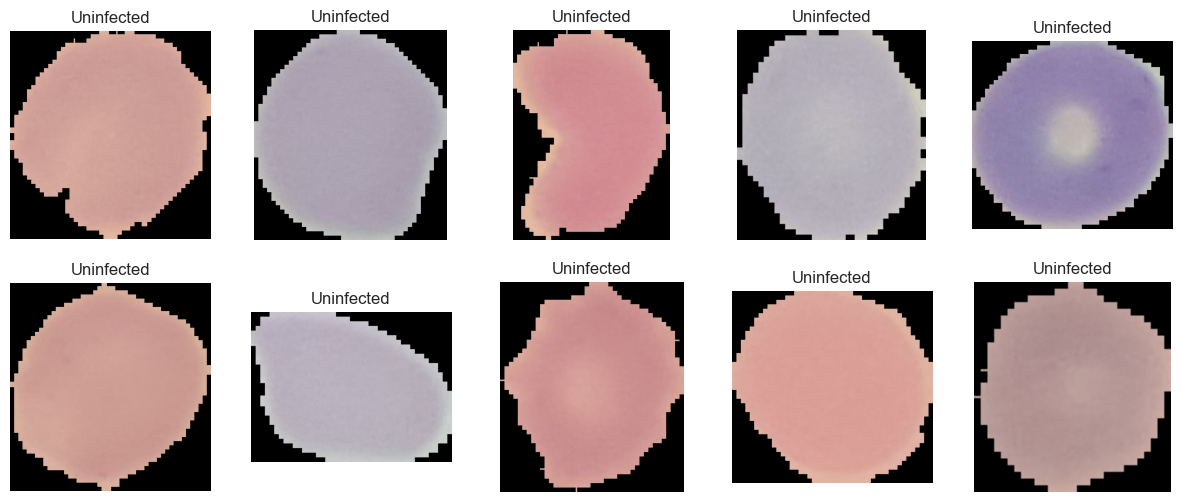

In [5]:
def show_random_images(folder, label, n=10):
    plt.figure(figsize=(15, 6))
    sample_images = random.sample(os.listdir(folder), n)
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.show()

show_random_images(parasitized_dir, "Parasitized", n=10)
show_random_images(uninfected_dir, "Uninfected", n=10)

100%|██████████| 13780/13780 [00:02<00:00, 4674.67it/s]


Average Width: 132.49, Average Height: 132.98


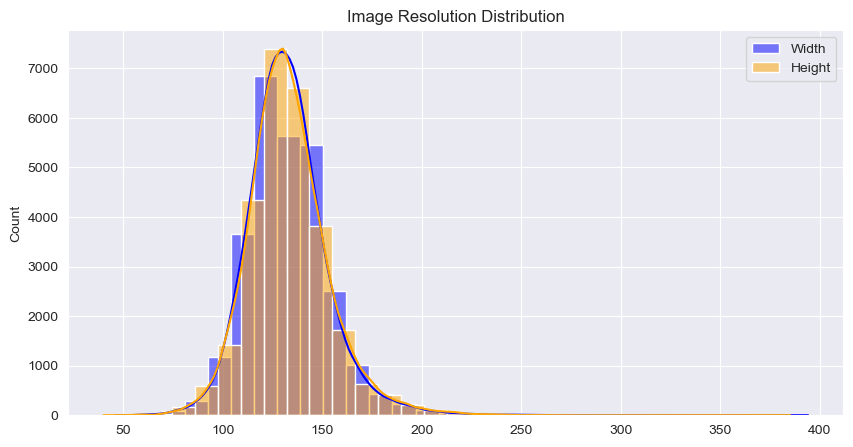

In [6]:
sizes = []
for folder in [parasitized_dir, uninfected_dir]:
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            sizes.append(img.size)  # (width, height)
        except:
            continue

widths, heights = zip(*sizes)
print(f"Average Width: {np.mean(widths):.2f}, Average Height: {np.mean(heights):.2f}")

plt.figure(figsize=(10,5))
sns.histplot(widths, bins=30, kde=True, color='blue', label='Width')
sns.histplot(heights, bins=30, kde=True, color='orange', label='Height')
plt.title("Image Resolution Distribution")
plt.legend()
plt.show()

In [7]:
def check_corrupted(folder):
    corrupted = []
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            img.verify()
        except:
            corrupted.append(img_name)
    return corrupted

corrupted_parasitized = check_corrupted(parasitized_dir)
corrupted_uninfected = check_corrupted(uninfected_dir)

print(f"Corrupted in Parasitized: {len(corrupted_parasitized)}")
print(f"Corrupted in Uninfected: {len(corrupted_uninfected)}")

100%|██████████| 13780/13780 [00:03<00:00, 4395.43it/s]

Corrupted in Parasitized: 1
Corrupted in Uninfected: 1


In [8]:
def dhash(image, size=8):
    image = image.convert('L').resize((size + 1, size), Image.ANTIALIAS)
    diff = np.array(image)[:, 1:] > np.array(image)[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

hashes = {}
duplicates = []

for folder in [parasitized_dir, uninfected_dir]:
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            h = dhash(img)
            if h in hashes:
                duplicates.append((hashes[h], img_path))
            else:
                hashes[h] = img_path
        except:
            continue

print(f"Found {len(duplicates)} near-duplicates.")

100%|██████████| 13780/13780 [00:08<00:00, 1715.01it/s]

Found 0 near-duplicates.
